In [2]:
from pymatgen.ext.matproj import MPRester
from pymatgen import Structure
from pymatgen.electronic_structure import bandstructure as bs
from pymatgen.electronic_structure import plotter as pl
import matplotlib.pyplot as plt
import numpy as np

In [3]:
with MPRester("olRvFz7OOr5I9QmQg44w") as m:

    # Structure for material id
    N2 = m.get_bandstructure_by_material_id("mp-672233")

This database version has changed from the database last accessed (2021_02_08).
Please see release notes on materialsproject.org for information about what has changed.


## 1/ Bande Interdite

In [41]:
Eg = N2.get_band_gap()["energy"]
print("La largeur de la bande interdite vaut :",Eg,"eV.\nOn peut l'observer ci-dessous, avec sa largeur représentée par la ligne verte.")

La largeur de la bande interdite vaut : 6.6026 eV.
On peut l'observer ci-dessous, avec sa largeur représentée par la ligne verte.


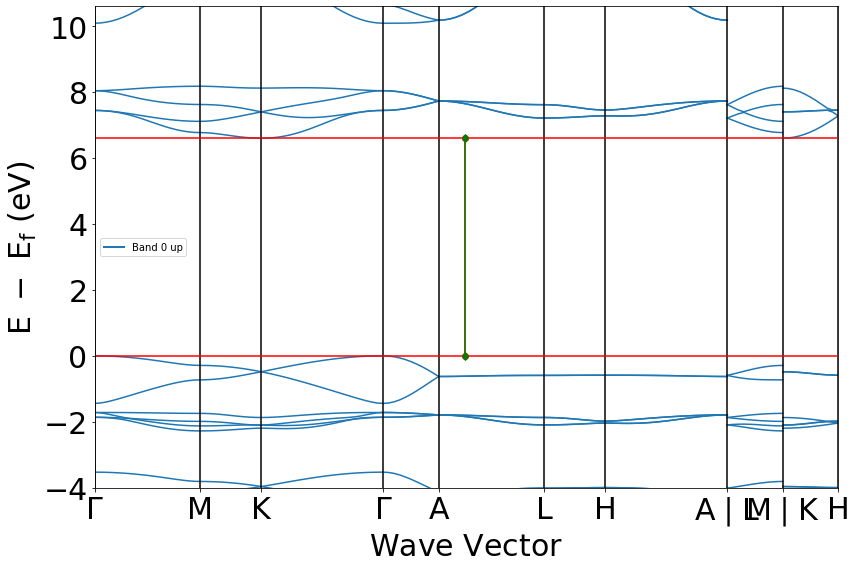

In [38]:
pl.BSPlotter(N2).get_plot()

x1, y1 = [-0.1, 6.5], [0, 0]
x2, y2 = [-0.1, 6.5], [6.6026, 6.6026]
x3, y3 = [3.15,3.15], [0,6.6026]

plt.plot(x1, y1, x2, y2,x3, y3,color = 'r', marker = 'o')
plt.plot(x3, y3, color = 'g', marker = 'd')

plt.show()

## 2/ Dispersion

Pour calculer la dispersion, on regarde la dérivée (la pente) de E par rapport à k. 

Pour ce faire on calcule delta(E)/delta(k) entre les différentes frontières de chemin pour récupèrer les minimums et maximums, ce qui nous donnera les lieux sur la bande où la dispersion est la plus petite (le minimum) et où elle est la plus grande (le maximum). 

In [33]:
data = pl.BSPlotter(N2).bs_plot_data()

dEdk_val = []
dEdk_cond = []
for i in range(len(data['distances'])) :#nombre de frontières de chemin
    
    dk = data['distances'][i][0]-data['distances'][i][-1]
    dE_val = data["energy"]['1'][i][9][0]-data["energy"]['1'][i][9][-1] #energies["1"][numéro du chemin][numéro de la bande][indice dans la liste]
    dE_cond = data["energy"]['1'][i][10][0]-data["energy"]['1'][i][10][-1]
    
    dEdk_val.append(abs(dE_val/dk))
    dEdk_cond.append(abs(dE_cond/dk))
 
print("La direction dans laquelle la dernière bande de valence présente le plus de dispersion est de k =",
      data['distances'][dEdk_val.index(max(dEdk_val))][0],
      " \nvers k=",data['distances'][dEdk_val.index(max(dEdk_val))][-1])
print("Dispersion minimale pour bande de valence : de k =",data['distances'][dEdk_val.index(min(dEdk_val))][0],"à",
     data['distances'][dEdk_val.index(min(dEdk_val))][-1])
print("Dispersion maximale pour bande de conduction: de k =",data['distances'][dEdk_cond.index(max(dEdk_cond))][0],"à",
     data['distances'][dEdk_cond.index(max(dEdk_cond))][-1])
print("Dispersion minimale pour bande de conduction: de k =",data['distances'][dEdk_cond.index(min(dEdk_cond))][0],"à",
     data['distances'][dEdk_cond.index(min(dEdk_cond))][-1])

La direction dans laquelle la dernière bande de valence présente le plus de dispersion est de k = 2.451228718847363  
1/m vers k= 2.9221831133361205 1/m
Dispersion minimale pour bande de valence : de k = 3.8193951006083333 1/m à 4.337400622495467 1/m
Dispersion maximale pour bande de conduction: de k = 5.84436622667225 1/m à 6.3153206211610105 1/m
Dispersion minimale pour bande de conduction: de k = 3.8193951006083333 1/m à 4.337400622495467 1/m


Représentées sur le graphe, on a :

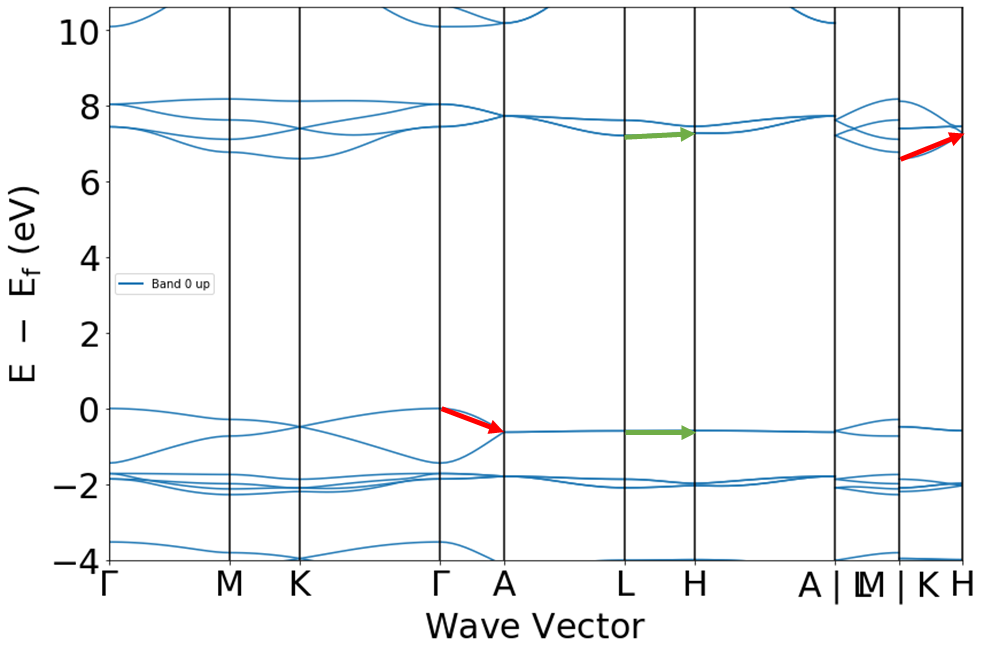

Avec les flèches rouges les directions de dispersions maximales, et les vertes les directions de dispersions minimales

Note : 
* La dernière bande de valence est la 9ème 
* La première bande de conduction est la 10ème

## 3/ Masse effective

Pour trouver la masse effective, on part de l'équation suivante:

$$\frac{1}{m_*} = \frac{1}{\hbar^2}\frac{\mathrm d^2}{\mathrm d k^2} \left( E \right)$$
On peut la réécrire sous la forme :
$$m_* = \frac{\hbar^2}{\frac{\mathrm d^2}{\mathrm d k^2} \left( E \right)}$$

Pour déterminer la dérivée seconde de l'énergie, on suppose une dispersion hyperbolique. Afin d'en tirer parti, on effectue une régression polynomiale de degré 2 en prenant les valeurs de E et k au sommet de la dernière  bande de valence ou à la base de la première bande de conduction, et aux 2 points les plus proches. 

Ainsi, on a tout ce qu'il faut pour calculer la masse effective. en remplaçant E et k par leur valeur au sommet  de la dernière  bande de valence et à la base de la première bande de conduction, on trouve la masse effective en ces points.

In [44]:
k= [0.0]
E_cond= [data["energy"]['1'][0][10][0]]
E_val = [0.0]

for i in range(len(data['distances'])-1) :#nombre de frontières de chemin -1
    k.append(data['distances'][i][0])
    E_val.append(data["energy"]['1'][i+1][9][0]) 
    E_cond.append(data["energy"]['1'][i+1][10][0])

print(E_val)
print(E_cond)
print("\nOn remarque qu'il y a 2 sommets pour la dernière bande de valence et la première bande de conduction,\non calcule alors la masse effective à chaque sommet/base.")

def mass_eff(k, E):
    poly_fit = np.polyfit(k,E, 2)
    h = 1.05371737*10**(-34)  
    return pow(h,2)/(2*poly_fit[0]*(1.602176565e-19)*10e-20)


Ec1=[data["energy"]['1'][1][10][-2],E_cond[2],data["energy"]['1'][2][10][1]]
Ec2=[data["energy"]['1'][7][10][-2],E_cond[8],data["energy"]['1'][8][10][1]]

kc1=[data['distances'][1][-2],data['distances'][2][0],data['distances'][2][1]]
kc2=[data['distances'][7][-2],data['distances'][8][0],data['distances'][8][1]]

Ev1=[E_val[0],data["energy"]['1'][0][9][1],data["energy"]['1'][0][9][2]]
Ev2=[data["energy"]['1'][2][9][-2],E_val[3],data["energy"]['1'][3][9][1]]

kv1=[data['distances'][0][0],data['distances'][0][1],data['distances'][0][2]] #Comme le maximum se situe à k=0, on prend ce point et les 2 suivants à droite.
kv2=[data['distances'][2][-2],data['distances'][3][0],data['distances'][3][1]]


print("\nLes masses effectives aux sommets de la dernière bande de valence valent : m* =",mass_eff(kv1,Ev1),
      "kg pour le premier sommet et m*=",mass_eff(kv2,Ev2), "kg pour le second.")
print("\nLes masses effectives aux bases de la dernière bande de conduction valent : m* =",mass_eff(kc1,Ec1),
      "kg pour la première base et m*=",mass_eff(kc2,Ec2), "kg pour la seconde.\n")

[0.0, -0.28939999999999966, -0.4817999999999998, 0.0, -0.6261000000000001, -0.5924999999999994, -0.5861000000000001, -0.5924999999999994, -0.4817999999999998]
[7.4467, 6.7742, 6.6026, 7.4467, 7.7328, 7.2148, 7.2813, 7.2148, 6.6026]

On remarque qu'il y a 2 sommets pour la dernière bande de valence et la première bande de conduction,
on calcule alors la masse effective à chaque sommet/base.

Les masses effectives aux sommets de la dernière bande de valence valent : m* = -6.149291292893582e-31 kg pour le premier sommet et m*= -1.8865876109737244e-31 kg pour le second.

Les masses effectives aux bases de la dernière bande de conduction valent : m* = 2.304587142304719e-31 kg pour la première base et m*= 8.308524070057266e-33 kg pour la seconde.

